# Real-NVP Based on Eric Janc's JAX impl

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers

from utils.masking import *
from utils.coupling import *

sns.reset_defaults()
sns.set_context(context='talk',font_scale=0.7)
plt.rcParams['image.cmap'] = 'viridis'

%matplotlib inline

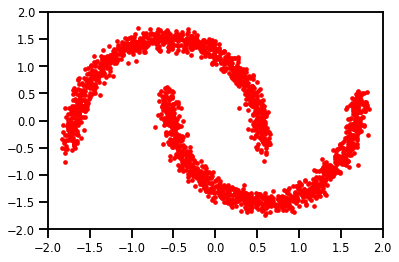

In [3]:
n_samples = 2000
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
X, y = noisy_moons
X = StandardScaler().fit_transform(X)
X = X.astype(np.float32)
y = y.astype(np.float32)
xlim, ylim = [-2, 2], [-2, 2]
plt.scatter(X[:, 0], X[:, 1], s=10, color='red')
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

# Real NVP

In [4]:
def fake_nn(x):
    return 0.1, 0.5

In [5]:
X.shape

(2000, 2)

In [26]:
X = X[np.newaxis,...]

In [27]:
X.shape

(1, 2000, 2)

In [127]:
def get_dense_net(units, in_shape):
    inputs = tfkl.Input(in_shape)
    x = tfkl.Dense(units=units, activation='sigmoid')(inputs)
    x = tfkl.Dense(units=units, activation='sigmoid')(x)
    
    shift = tfkl.Dense(units=1, activation='linear')(x)
    log_scale = tfkl.Dense(units=1, activation='linear')(x)
    
    model = tfk.models.Model(inputs=inputs, outputs=[shift, log_scale])
    
    return model

In [128]:
bijectors = [
    tfb.BatchNormalization(),
    Coupling(
        shift_and_log_scale_fn=get_dense_net(units=32, in_shape=X.shape[1:]),
        mask_fn=MaskCheckerboard(flip=False),
    ),
    tfb.BatchNormalization(),
    Coupling(
        shift_and_log_scale_fn=get_dense_net(units=32, in_shape=X.shape[1:]),
        mask_fn=MaskCheckerboard(flip=True),
    ),
    tfb.BatchNormalization(),
    Coupling(
        shift_and_log_scale_fn=get_dense_net(units=32, in_shape=X.shape[1:]),
        mask_fn=MaskCheckerboard(flip=False),
    ),
    tfb.BatchNormalization(),
    Coupling(
        shift_and_log_scale_fn=get_dense_net(units=32, in_shape=X.shape[1:]),
        mask_fn=MaskCheckerboard(flip=True),
    ),
]



bijector_model = tfb.Chain(list(reversed(bijectors)))

In [129]:
bijector_model.forward_log_det_jacobian(X, event_ndims=1)

<tf.Tensor: shape=(1, 2000), dtype=float32, numpy=
array([[0.26511377, 0.41392082, 0.24632722, ..., 0.28531224, 0.2404427 ,
        0.38959187]], dtype=float32)>

In [130]:
bijector_model.inverse_log_det_jacobian(X, event_ndims=1)

Instructions for updating:
Please use `layer.__call__` method instead.


<tf.Tensor: shape=(1, 2000), dtype=float32, numpy=
array([[15.090339, 14.898414, 15.026519, ..., 14.884725, 15.041221,
        14.919536]], dtype=float32)>

In [131]:
(bijector_model.inverse(bijector_model.forward(X)) == X).numpy().all()

True

In [132]:
(bijector_model.forward(bijector_model.inverse(X)) == X).numpy().all()

True

In [133]:
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], dtype=tf.float32))

In [134]:
flow = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=bijector_model,
)

In [135]:
def negloglik(x, rv_x):
    return -tf.reduce_mean(rv_x.log_prob(x))

In [136]:
negloglik(X, flow)

<tf.Tensor: shape=(), dtype=float32, numpy=-12.163924>

In [137]:
opt = tf.optimizers.Adam(learning_rate=1e-4)
loss_obj = tf.keras.metrics.Mean(name='loss', dtype=tf.float32)

In [139]:
N_EPOCHS = 100

for cur_epoch in range(N_EPOCHS):
    with tf.GradientTape() as tape:
        loss = negloglik(X, flow)
    loss_obj.update_state(loss)
    grads = tape.gradient(loss, flow.trainable_variables)
    opt.apply_gradients(zip(grads, flow.trainable_variables))
    
    if cur_epoch % 10 == 0:
        print(loss_obj.result().numpy())

-12.163924
-12.860096
-13.708409
-14.888429
-16.054258
-17.084394
-17.996819
-18.753922
-19.394783
-19.975195


In [140]:
out = flow.sample((1, 2000))

In [141]:
out.shape

TensorShape([1, 2000, 2])

In [142]:
out

<tf.Tensor: shape=(1, 2000, 2), dtype=float32, numpy=
array([[[ 0.00221762, -0.        ],
        [-0.        ,  0.00209506],
        [ 0.00221762, -0.        ],
        ...,
        [-0.        ,  0.00209506],
        [ 0.00221762, -0.        ],
        [-0.        ,  0.00209506]]], dtype=float32)>

In [143]:
X.shape

(1, 2000, 2)

In [144]:
xlim, ylim = [-2, 2], [-2, 2]
plt.scatter(out[:, 0], out[:, 1], s=10, color='blue')
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()

# TODO: checkerboard might be broken?